In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from loaddata import load_data
import missingno as msno

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor
from pyod.models.auto_encoder import AutoEncoder

from sklearn.metrics import adjusted_rand_score, recall_score, roc_auc_score, fowlkes_mallows_score, silhouette_score

Using TensorFlow backend.


In [4]:
dirname = os.getcwd()
path = os.path.join(dirname, "CMAPSSData")
dc = load_data(path=path)
df = dc['FD_001']['df_train'].copy()
na_list = df.columns[df.isna().any()].tolist()
const_list = [col for col in df.columns if len(df[col].unique()) <= 2] 
df.drop(columns=na_list+const_list,axis=1, inplace=True)
df.describe()

,unit_num,cycle_time,os1,os2,sensor_02,sensor_03,sensor_04,sensor_07,sensor_08,sensor_09,sensor_11,sensor_12,sensor_13,sensor_14,sensor_15,sensor_17,sensor_20,sensor_21
count,20631.000000,20631.000000,20631.000000,20631.000000,20631.000000,20631.000000,20631.000000,20631.000000,20631.000000,20631.000000,20631.000000,20631.000000,20631.000000,20631.000000,20631.000000,20631.000000,20631.000000,20631.000000
mean,51.506568,108.807862,-0.000009,0.000002,642.680934,1590.523119,1408.933782,553.367711,2388.096652,9065.242941,47.541168,521.413470,2388.096152,8143.752722,8.442146,393.210654,38.816271,23.289705
std,29.227633,68.880990,0.002187,0.000293,0.500053,6.131150,9.000605,0.885092,0.070985,22.082880,0.267087,0.737553,0.071919,19.076176,0.037505,1.548763,0.180746,0.108251
min,1.000000,1.000000,-0.008700,-0.000600,641.210000,1571.040000,1382.250000,549.850000,2387.900000,9021.730000,46.850000,518.690000,2387.880000,8099.940000,8.324900,388.000000,38.140000,22.894200
25%,26.000000,52.000000,-0.001500,-0.000200,642.325000,1586.260000,1402.360000,552.810000,2388.050000,9053.100000,47.350000,520.960000,2388.040000,8133.245000,8.414900,392.000000,38.700000,23.221800
50%,52.000000,104.000000,0.000000,0.000000,642.640000,1590.100000,1408.040000,553.440000,2388.090000,9060.660000,47.510000,521.480000,2388.090000,8140.540000,8.438900,393.000000,38.830000,23.297900
75%,77.000000,156.000000,0.001500,0.000300,643.000000,1594.380000,1414.555000,554.010000,2388.140000,9069.420000,47.700000,521.950000,2388.140000,8148.310000,8.465600,394.000000,38.950000,23.366800
max,100.000000,362.000000,0.008700,0.000600,644.530000,1616.910000,1441.490000,556.060000,2388.560000,9244.590000,48.530000,523.380000,2388.560000,8293.720000,8.584800,400.000000,39.430000,23.618400


In [5]:
units = df["unit_num"].unique().tolist()
dicti = {}
for i in units:
    dicti[i] = df[df["unit_num"] == i]["cycle_time"].max() 
df["RUL"] = df["unit_num"].apply(lambda key: dicti[key]) - df["cycle_time"]
df.head()

,unit_num,cycle_time,os1,os2,sensor_02,sensor_03,sensor_04,sensor_07,sensor_08,sensor_09,sensor_11,sensor_12,sensor_13,sensor_14,sensor_15,sensor_17,sensor_20,sensor_21,RUL
0,1,1,-0.0007,-0.0004,641.82,1589.70,1400.60,554.36,2388.06,9046.19,47.47,521.66,2388.02,8138.62,8.4195,392,39.06,23.4190,191
1,1,2,0.0019,-0.0003,642.15,1591.82,1403.14,553.75,2388.04,9044.07,47.49,522.28,2388.07,8131.49,8.4318,392,39.00,23.4236,190
2,1,3,-0.0043,0.0003,642.35,1587.99,1404.20,554.26,2388.08,9052.94,47.27,522.42,2388.03,8133.23,8.4178,390,38.95,23.3442,189
3,1,4,0.0007,0.0000,642.35,1582.79,1401.87,554.45,2388.11,9049.48,47.13,522.86,2388.08,8133.83,8.3682,392,38.88,23.3739,188
4,1,5,-0.0019,-0.0002,642.37,1582.85,1406.22,554.00,2388.06,9055.15,47.28,522.19,2388.04,8133.80,8.4294,393,38.90,23.4044,187


In [7]:
df["RUL_clf"] = [1 if i <= 40 else 0 for i in df["RUL"] ]
df["RUL_clf"]

0        0
1        0
2        0
3        0
4        0
        ..
20626    1
20627    1
20628    1
20629    1
20630    1
Name: RUL_clf, Length: 20631, dtype: int64

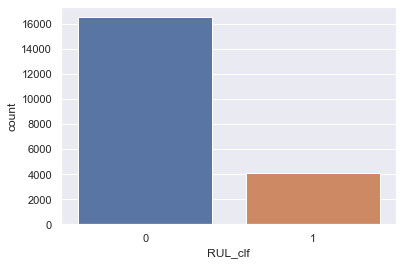

0    16531
1     4100
Name: RUL_clf, dtype: int64


In [10]:
sns.countplot(x="RUL_clf",data=df)
plt.show()
print(df["RUL_clf"].value_counts())
df.drop("RUL",axis=1, inplace=True)

In [21]:
def get_clf_model_metrics(model,actual,predicted):
    
    clf_metrics = {
                        "Adjusted Rand Score": adjusted_rand_score(actual, predicted),
                        "Fowlkes Mallows Score":fowlkes_mallows_score(actual, predicted),
                        "Recall Score": recall_score(actual, predicted),
                        "Auc Score": roc_auc_score(actual, predicted),     
                  }
    
    df_clf_metrics = pd.DataFrame.from_dict(clf_metrics, orient='index')
    df_clf_metrics.columns = [model]
    
    return df_clf_metrics

In [25]:
def fit_model(model, data):
    
    
    X = df.drop(["os1","os2","RUL_clf","sensor_14"],axis=1)
    y = df["RUL_clf"].values
    
    i = 0
    
    for name, clf in model.items():
        print("Fitting model: " + name)
        clf.fit(X)
        
        if name == "K-Means":
            y_pred = clf.predict(X)
            y_pred = (y_pred == 0).astype(int)
            
        elif name == "Auto Encoder":
            y_pred = clf.predict(X)
            
        else:
            y_pred = clf.predict(X)
            y_pred = (y_pred == -1).astype(int)
            
        if i == 0:
            metrics = get_clf_model_metrics(name, y, y_pred)
            print(metrics)
            
        elif i != 0:
            new_metric = get_clf_model_metrics(name, y, y_pred)
            print(new_metric)
            metrics = pd.concat([metrics, new_metric],axis=1)
            
        i= i+1
        print("\n\n")
        
    return metrics

In [26]:
model = {    
     "One Class SVM": OneClassSVM(),
     "Local Outlier Factor": LocalOutlierFactor(contamination=0.248, novelty=True),
     "K-Means": KMeans(n_clusters = 2, random_state = 42),
     "Isolation Forest": IsolationForest(n_estimators=100, random_state=42, n_jobs=-1, contamination=0.248),
     "Auto Encoder": AutoEncoder(hidden_neurons =[20, 12, 12, 20],contamination = 0.248),
}

In [27]:
fit_model(model, df)

Fitting model: One Class SVM
                       One Class SVM
Adjusted Rand Score         0.027017
Fowlkes Mallows Score       0.595300
Recall Score                0.707317
Auc Score                   0.629262



Fitting model: Local Outlier Factor
                       Local Outlier Factor
Adjusted Rand Score                0.005806
Fowlkes Mallows Score              0.666761
Recall Score                       0.237317
Auc Score                          0.506143



Fitting model: K-Means
                        K-Means
Adjusted Rand Score    0.252667
Fowlkes Mallows Score  0.695814
Recall Score           0.963171
Auc Score              0.832623



Fitting model: Isolation Forest
                       Isolation Forest
Adjusted Rand Score            0.370995
Fowlkes Mallows Score          0.782479
Recall Score                   0.690000
Auc Score                      0.775797



Fitting model: Auto Encoder
Model: "sequential_3"
_____________________________________________________

18567/18567 [==============================] - 1s 49us/step - loss: 1.0001 - val_loss: 0.9990
Epoch 50/100
18567/18567 [==============================] - 1s 49us/step - loss: 1.0001 - val_loss: 0.9990
Epoch 51/100
18567/18567 [==============================] - 1s 50us/step - loss: 1.0001 - val_loss: 0.9990
Epoch 52/100
18567/18567 [==============================] - 1s 50us/step - loss: 1.0001 - val_loss: 0.9990
Epoch 53/100
18567/18567 [==============================] - 1s 49us/step - loss: 1.0001 - val_loss: 0.9990
Epoch 54/100
18567/18567 [==============================] - 1s 50us/step - loss: 1.0001 - val_loss: 0.9990
Epoch 55/100
18567/18567 [==============================] - 1s 47us/step - loss: 1.0001 - val_loss: 0.9990
Epoch 56/100
18567/18567 [==============================] - 1s 48us/step - loss: 1.0001 - val_loss: 0.9990
Epoch 57/100
18567/18567 [==============================] - 1s 50us/step - loss: 1.0001 - val_loss: 0.9990
Epoch 58/100
18567/18567 [========================

,One Class SVM,Local Outlier Factor,K-Means,Isolation Forest,Auto Encoder
Adjusted Rand Score,0.027017,0.005806,0.252667,0.370995,0.385371
Fowlkes Mallows Score,0.595300,0.666761,0.695814,0.782479,0.787471
Recall Score,0.707317,0.237317,0.963171,0.690000,0.702439
Auc Score,0.629262,0.506143,0.832623,0.775797,0.783559
